# Bayesian Poisson Regression
This notebook is ported from the [example notebook](https://docs.pymc.io/notebooks/GLM-poisson-regression.html) of PyMC3 on Poisson Regression.  

[Poisson Regression](https://en.wikipedia.org/wiki/Poisson_regression) is a technique commonly used to model count data. Some of the applications include predicting the number of people defaulting on their loans or the number of cars running on a highway on a given day.This example describes a method to implement the Bayesian version of this technique using Turing.

We will generate the dataset that we will be working on which describes the relationship between number of times a person sneezes during the day with his alcohol consumption and medicinal intake.

We start by importing the required libraries.

In [1]:
#Import Turing, Distributions and DataFrames
using Turing, Distributions, DataFrames, Distributed

# Import MCMCChain, Plots, and StatsPlots for visualizations and diagnostics.
using MCMCChains, Plots, StatsPlots

# Set a seed for reproducibility.
using Random
Random.seed!(12);

# Turn off progress monitor.
Turing.turnprogress(false)

loaded


┌ Info: [Turing]: global PROGRESS is set as false
└ @ Turing /home/saumya/.julia/packages/Turing/r03H1/src/Turing.jl:24


false

# Generating data
We start off by creating a toy dataset. We take the case of a person who takes medicines to prevent excessive sneezing. Alcohol consumption increases the rate of sneezing for that person. Thus, the two factors affecting the number of sneezes in a given day are alcohol consumption and whether the person has taken his medicine. Both these variable are taken as boolean valued while the number of sneezes will be a count valued variable. We also take into consideration that the interaction between the two boolean variables will affect the number of sneezes

The first and the last 10 lines are printed to get a gist of the data generated.

In [2]:
theta_noalcohol_meds = 1    # no alcohol, took a medicine
theta_alcohol_meds = 3      # alcohol, took a medicine
theta_noalcohol_nomeds = 6  # no alcohol, no medicine
theta_alcohol_nomeds = 36   # alcohol, no medicine

# no of samples for each of the above cases
q = 1000

#Generate data from different Poisson distributions
noalcohol_meds = Poisson(theta_noalcohol_meds)
alcohol_meds = Poisson(theta_alcohol_meds)
noalcohol_nomeds = Poisson(theta_noalcohol_nomeds)
alcohol_nomeds = Poisson(theta_alcohol_nomeds)

nsneeze_data = vcat(rand(noalcohol_meds, q), rand(alcohol_meds, q), rand(noalcohol_nomeds, q), rand(alcohol_nomeds, q) )
alcohol_data = vcat(zeros(q), ones(q), zeros(q), ones(q) )
meds_data = vcat(zeros(q), zeros(q), ones(q), ones(q) )

df = DataFrame(nsneeze = nsneeze_data, alcohol_taken = alcohol_data, nomeds_taken = meds_data, product_alcohol_meds = meds_data.*alcohol_data)
first(df, 10), last(df, 10)

(10×4 DataFrame
│ Row │ nsneeze │ alcohol_taken │ nomeds_taken │ product_alcohol_meds │
│     │ Int64   │ Float64       │ Float64      │ Float64              │
├─────┼─────────┼───────────────┼──────────────┼──────────────────────┤
│ 1   │ 0       │ 0.0           │ 0.0          │ 0.0                  │
│ 2   │ 3       │ 0.0           │ 0.0          │ 0.0                  │
│ 3   │ 1       │ 0.0           │ 0.0          │ 0.0                  │
│ 4   │ 1       │ 0.0           │ 0.0          │ 0.0                  │
│ 5   │ 3       │ 0.0           │ 0.0          │ 0.0                  │
│ 6   │ 2       │ 0.0           │ 0.0          │ 0.0                  │
│ 7   │ 3       │ 0.0           │ 0.0          │ 0.0                  │
│ 8   │ 1       │ 0.0           │ 0.0          │ 0.0                  │
│ 9   │ 0       │ 0.0           │ 0.0          │ 0.0                  │
│ 10  │ 0       │ 0.0           │ 0.0          │ 0.0                  │, 10×4 DataFrame
│ Row │ nsneeze │ alcohol_taken 

# Visualisation of the dataset
We plot the distribution of the number of sneezes for the 4 different cases taken above. As expected, the person sneezes the most when he has taken alcohol and not taken his medicines. He sneezes the least when he doesn't consume alcohol and takes his medicines

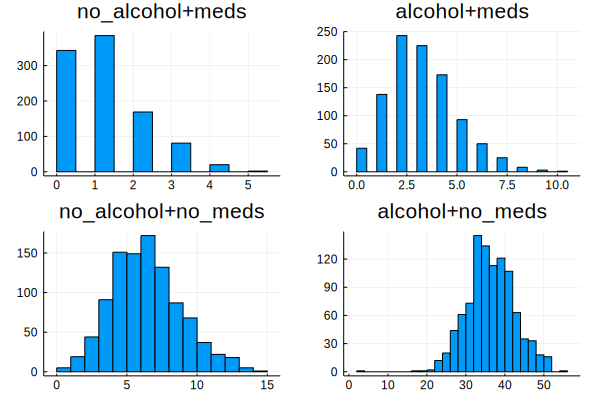

In [3]:
#Data Plotting

p1 = Plots.histogram(df[1:1000, 1], title = "no_alcohol+meds")  
p2 = Plots.histogram((df[1000:2000, 1]), title = "alcohol+meds")  
p3 = Plots.histogram((df[2000:3000, 1]), title = "no_alcohol+no_meds")  
p4 = Plots.histogram((df[3000:4000, 1]), title = "alcohol+no_meds")  
plot(p1, p2, p3, p4, layout = (2, 2), legend = false)

We must convert our `DataFrame` data into the `Matrix` form as the manipulations that we are about are designed to work with `Matrix` data. We also separate the features from the labels which will be later used by the Turing sampler to generate samples from the posterior.

In [4]:
# Convert the DataFrame object to matrices.
data = Matrix(df[[:alcohol_taken, :nomeds_taken, :product_alcohol_meds]])
data_labels = df[:nsneeze]
data

4000×3 Array{Float64,2}:
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 ⋮            
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0

We must recenter our data about 0 to help the Turing sampler in initialising the parameter estimates. So, normalising the data in each column by subtracting the mean and dividing by the standard deviation:

In [5]:
# # Rescale our matrices.
data = (data .- mean(data, dims=1)) ./ std(data, dims=1)

4000×3 Array{Float64,2}:
 -0.999875  -0.999875  -0.577278
 -0.999875  -0.999875  -0.577278
 -0.999875  -0.999875  -0.577278
 -0.999875  -0.999875  -0.577278
 -0.999875  -0.999875  -0.577278
 -0.999875  -0.999875  -0.577278
 -0.999875  -0.999875  -0.577278
 -0.999875  -0.999875  -0.577278
 -0.999875  -0.999875  -0.577278
 -0.999875  -0.999875  -0.577278
 -0.999875  -0.999875  -0.577278
 -0.999875  -0.999875  -0.577278
 -0.999875  -0.999875  -0.577278
  ⋮                             
  0.999875   0.999875   1.73183 
  0.999875   0.999875   1.73183 
  0.999875   0.999875   1.73183 
  0.999875   0.999875   1.73183 
  0.999875   0.999875   1.73183 
  0.999875   0.999875   1.73183 
  0.999875   0.999875   1.73183 
  0.999875   0.999875   1.73183 
  0.999875   0.999875   1.73183 
  0.999875   0.999875   1.73183 
  0.999875   0.999875   1.73183 
  0.999875   0.999875   1.73183 

# Declaring the Model: Poisson Regression
Our model, `poisson_regression` takes four arguments:

- `x` is our set of independent variables;
- `y` is the element we want to predict;
- `n` is the number of observations we have; and
- `σ²` is the standard deviation we want to assume for our priors.

Within the model, we create four coefficients (`b0`, `b1`, `b2`, and `b3`) and assign a prior of normally distributed with means of zero and standard deviations of `σ²`. We want to find values of these four coefficients to predict any given `y`. 

Intuitively, we can think of the coefficients as:

- `b1` is the coefficient which represents the effect of taking alcohol on the number of sneezes; 
- `b2` is the coefficient which represents the effect of taking in no medicines on the number of sneezes; 
- `b3` is the coefficient which represents the effect of interaction between taking alcohol and no medicines on the number of sneezes; 

The `for` block creates a variable `theta` which is the weighted combination of the input features. We have defined the priors on these weights above. We then observe the likelihood of calculating `theta` given the actual label, `y[i]`.

In [6]:
# Bayesian poisson regression (LR)
@model poisson_regression(x, y, n, σ²) = begin
    b0 ~ Normal(0, σ²)
    b1 ~ Normal(0, σ²)
    b2 ~ Normal(0, σ²)
    b3  ~ Normal(0, σ²)
#     y = tzeros(Int, n)
    for i = 1:n
        theta = b0 + b1*x[i, 1] + b2*x[i,2] + b3*x[i,3]
        y[i] ~ Poisson(exp(theta))
    end
end;

# Sampling from the posterior
We use the `NUTS` sampler to sample values from the posterior. We run multiple chains using the `mapreduce` function to nullify the effect of a problematic chain. We then use the Gelman, Rubin, and Brooks Diagnostic to check the convergence of these multiple chains.

In [7]:
# This is temporary while the reverse differentiation backend is being improved.
Turing.setadbackend(:forward_diff)

# Retrieve the number of observations.
n, _ = size(data)

# Sample using NUTS.

num_chains = 4
chains = mapreduce(c -> sample(poisson_regression(data, data_labels, n, 10), NUTS(1500, 200, 0.65) ), chainscat, 1:num_chains)

┌ Info: [Turing] looking for good initial eps...
└ @ Turing.Inference /home/saumya/.julia/packages/Turing/r03H1/src/inference/support/hmc_core.jl:240
┌ Warning: Numerical error has been found in gradients.
└ @ Turing.Core /home/saumya/.julia/packages/Turing/r03H1/src/core/ad.jl:169
┌ Warning: grad = Real[NaN, NaN, NaN, NaN]
└ @ Turing.Core /home/saumya/.julia/packages/Turing/r03H1/src/core/ad.jl:170
┌ Warning: Numerical error has been found in gradients.
└ @ Turing.Core /home/saumya/.julia/packages/Turing/r03H1/src/core/ad.jl:169
┌ Warning: grad = Real[NaN, NaN, NaN, NaN]
└ @ Turing.Core /home/saumya/.julia/packages/Turing/r03H1/src/core/ad.jl:170
┌ Warning: Numerical error has been found in gradients.
└ @ Turing.Core /home/saumya/.julia/packages/Turing/r03H1/src/core/ad.jl:169
┌ Warning: grad = Real[NaN, NaN, NaN, NaN]
└ @ Turing.Core /home/saumya/.julia/packages/Turing/r03H1/src/core/ad.jl:170
┌ Warning: Numerical error has been found in gradients.
└ @ Turing.Core /home/saumya/.julia

[NUTS] Finished with
  Running time        = 721.5819472870003;
  #lf / sample        = 0.0;
  #evals / sample     = 45.092;
  pre-cond. metric    = [1.0, 1.0, 1.0, 1.0].


┌ Info: [Turing] looking for good initial eps...
└ @ Turing.Inference /home/saumya/.julia/packages/Turing/r03H1/src/inference/support/hmc_core.jl:240
┌ Warning: Numerical error has been found in gradients.
└ @ Turing.Core /home/saumya/.julia/packages/Turing/r03H1/src/core/ad.jl:169
┌ Warning: grad = Real[NaN, NaN, NaN, NaN]
└ @ Turing.Core /home/saumya/.julia/packages/Turing/r03H1/src/core/ad.jl:170
┌ Warning: Numerical error has been found in gradients.
└ @ Turing.Core /home/saumya/.julia/packages/Turing/r03H1/src/core/ad.jl:169
┌ Warning: grad = Real[NaN, NaN, NaN, NaN]
└ @ Turing.Core /home/saumya/.julia/packages/Turing/r03H1/src/core/ad.jl:170
┌ Warning: Numerical error has been found in gradients.
└ @ Turing.Core /home/saumya/.julia/packages/Turing/r03H1/src/core/ad.jl:169
┌ Warning: grad = Real[NaN, NaN, NaN, NaN]
└ @ Turing.Core /home/saumya/.julia/packages/Turing/r03H1/src/core/ad.jl:170
┌ Warning: Numerical error has been found in gradients.
└ @ Turing.Core /home/saumya/.julia

[NUTS] Finished with
  Running time        = 661.6507120890008;
  #lf / sample        = 0.0;
  #evals / sample     = 40.846;
  pre-cond. metric    = [1.0, 1.0, 1.0, 1.0].


┌ Info: [Turing] looking for good initial eps...
└ @ Turing.Inference /home/saumya/.julia/packages/Turing/r03H1/src/inference/support/hmc_core.jl:240
┌ Warning: Numerical error has been found in gradients.
└ @ Turing.Core /home/saumya/.julia/packages/Turing/r03H1/src/core/ad.jl:169
┌ Warning: grad = Real[NaN, NaN, NaN, NaN]
└ @ Turing.Core /home/saumya/.julia/packages/Turing/r03H1/src/core/ad.jl:170
┌ Warning: Numerical error has been found in gradients.
└ @ Turing.Core /home/saumya/.julia/packages/Turing/r03H1/src/core/ad.jl:169
┌ Warning: grad = Real[NaN, NaN, NaN, NaN]
└ @ Turing.Core /home/saumya/.julia/packages/Turing/r03H1/src/core/ad.jl:170
┌ Warning: Numerical error has been found in gradients.
└ @ Turing.Core /home/saumya/.julia/packages/Turing/r03H1/src/core/ad.jl:169
┌ Warning: grad = Real[NaN, NaN, NaN, NaN]
└ @ Turing.Core /home/saumya/.julia/packages/Turing/r03H1/src/core/ad.jl:170
┌ Warning: Numerical error has been found in gradients.
└ @ Turing.Core /home/saumya/.julia

[NUTS] Finished with
  Running time        = 677.2134531950004;
  #lf / sample        = 0.0;
  #evals / sample     = 41.936;
  pre-cond. metric    = [1.0, 1.0, 1.0, 1.0].


┌ Info: [Turing] looking for good initial eps...
└ @ Turing.Inference /home/saumya/.julia/packages/Turing/r03H1/src/inference/support/hmc_core.jl:240
┌ Warning: Numerical error has been found in gradients.
└ @ Turing.Core /home/saumya/.julia/packages/Turing/r03H1/src/core/ad.jl:169
┌ Warning: grad = Real[NaN, NaN, NaN, NaN]
└ @ Turing.Core /home/saumya/.julia/packages/Turing/r03H1/src/core/ad.jl:170
┌ Warning: Numerical error has been found in gradients.
└ @ Turing.Core /home/saumya/.julia/packages/Turing/r03H1/src/core/ad.jl:169
┌ Warning: grad = Real[NaN, NaN, NaN, NaN]
└ @ Turing.Core /home/saumya/.julia/packages/Turing/r03H1/src/core/ad.jl:170
┌ Warning: Numerical error has been found in gradients.
└ @ Turing.Core /home/saumya/.julia/packages/Turing/r03H1/src/core/ad.jl:169
┌ Warning: grad = Real[NaN, NaN, NaN, NaN]
└ @ Turing.Core /home/saumya/.julia/packages/Turing/r03H1/src/core/ad.jl:170
┌ Warning: Numerical error has been found in gradients.
└ @ Turing.Core /home/saumya/.julia

[NUTS] Finished with
  Running time        = 716.7530174479998;
  #lf / sample        = 0.0;
  #evals / sample     = 44.624;
  pre-cond. metric    = [1.0, 1.0, 1.0, 1.0].


Object of type Chains, with data of type 1500×10×4 Array{Union{Missing, Float64},3}

Log evidence      = 0.0
Iterations        = 1:1500
Thinning interval = 1
Chains            = 1, 2, 3, 4
Samples per chain = 1500
internals         = elapsed, epsilon, eval_num, lf_eps, lf_num, lp
parameters        = b3, b0, b2, b1

parameters
    Mean    SD   Naive SE  MCSE     ESS  
b0 1.6207 0.0955   0.0012 0.0047 407.5349
b1 0.5238 0.0341   0.0004 0.0019 323.8752
b2 0.8561 0.0431   0.0006 0.0021 429.7008
b3 0.3313 0.0518   0.0007 0.0029 323.0345



# Viewing the Diagnostics 

In [9]:
gelmandiag(chains)

Log evidence      = 0.0
Iterations        = 1:1500
Thinning interval = 1
Chains            = 1, 2, 3, 4
Samples per chain = 1500
internals         = elapsed, epsilon, eval_num, lf_eps, lf_num, lp
parameters        = b3, b0, b2, b1

Gelman, Rubin, and Brooks Diagnostic:
          PSRF 97.5%
      b0 1.024 1.026
      b1 1.027 1.037
      b2 1.021 1.024
      b3 1.014 1.018
 elapsed 1.003 1.008
 epsilon 1.017 1.026
eval_num 1.004 1.010
  lf_eps 1.017 1.026
  lf_num   NaN   NaN
      lp 1.084 1.086



From the above diagnostic, we can conclude that the chains have converged because the PSRF values of the coefficients are close to 1. 

So, we have obtained the posterior distributions of the parameters. We visualise the posterior by plotting it. We transform the coefficients and recover theta values by taking the exponent of the meaned values of the coefficients `b0`, `b1`, `b2` and `b3`. We then compare this with the intuitive meaning that was described earlier. 

The exponent of the meaned values of the weights (or coefficients are): 
b0: 5.0450776045657495 
b1: 1.6869970095011413 
b2: 2.352128717965939 
b3: 1.3962562142281951 
The posterior distributions obtained after sampling can be visualised as :


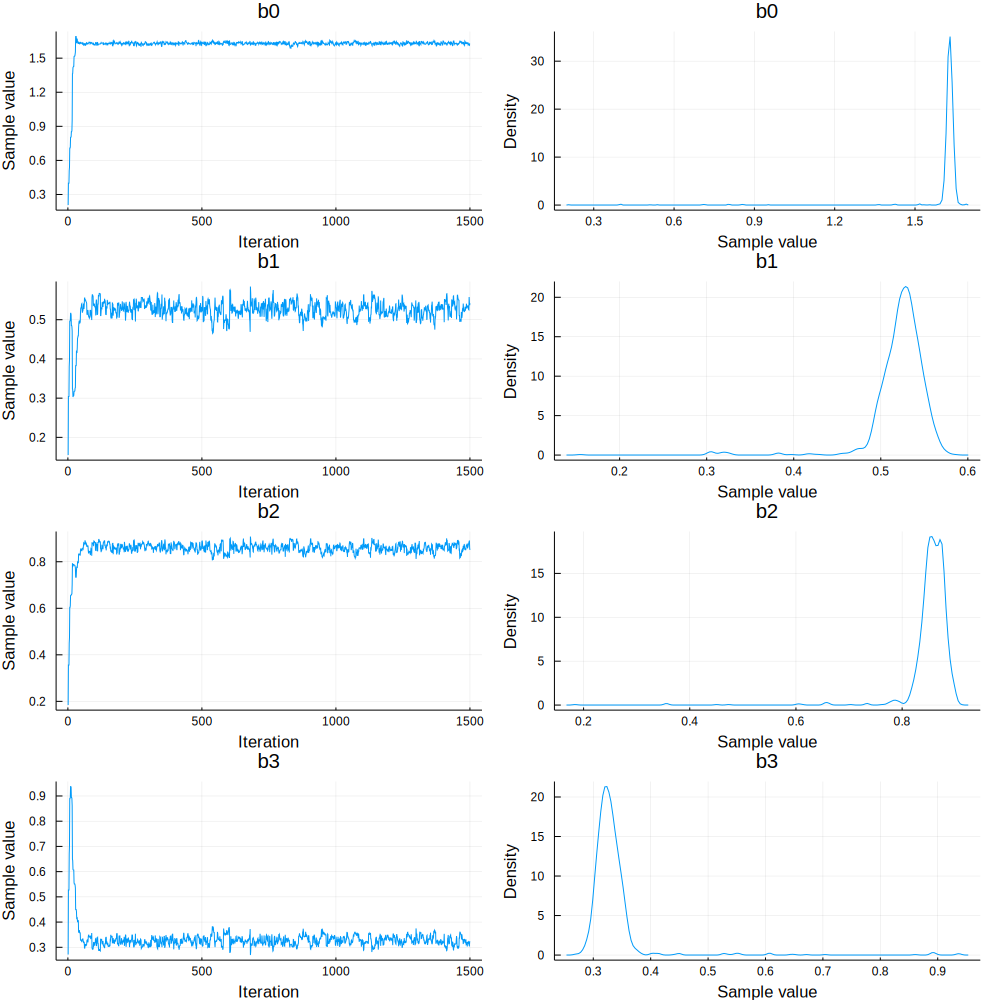

In [22]:
chain = chains[:,:,1]
b0_exp = exp(mean(chain[:b0]))
b1_exp = exp(mean(chain[:b1]))
b2_exp = exp(mean(chain[:b2]))
b3_exp = exp(mean(chain[:b3]))
print("The exponent of the meaned values of the weights (or coefficients are): \n")
print("b0: ", b0_exp, " \n", "b1: ", b1_exp, " \n", "b2: ", b2_exp, " \n", "b3: ", b3_exp, " \n")
print("The posterior distributions obtained after sampling can be visualised as :\n")
plot(chain)

# Interpreting the Obtained Mean Values
The exponentiated mean of the coefficient `b1` is roughly half of that of `b2` which makes sense because in the data that we generated, the number of sneezes was more sensitive to the medicinal intake as compared to the alcohol consumption. We also get a weaker dependence on the interaction between the alcohol consumption and the medicinal intake as can be seen from the value of `b3`.